In [58]:
import kagglehub
import shutil
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE

## Funciones auxiliares

In [59]:
# Funciones auxiliares

def plot_distribution(y, title):
    """
    Muestra la distribución de clases en un gráfico de barras.

    Parámetros:
    - y: etiquetas de las clases
    - title: título del gráfico
    """
    counter = Counter(y)
    print(f"Distribución de clases ({title}):", counter)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de muestras")
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, feature_name, label_map):
    """
    Genera y muestra una matriz de confusión con etiquetas legibles.

    Parámetros:
    - y_true: etiquetas reales
    - y_pred: etiquetas predichas
    - feature_name: nombre del extractor de características usado
    - label_map: diccionario de etiquetas de las clases
    - title_suffix: texto adicional para el título (ej. "antes de SMOTE" o "después de SMOTE")
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {feature_name}")
    plt.show()


def train_model(X, y):
    """
    Entrena un modelo SVM con los datos proporcionados.

    Parámetros:
    - X: características de entrada
    - y: etiquetas

    Retorna:
    - X_train, X_test, y_train, y_test, y_pred
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    svm = SVC(kernel='linear', class_weight='balanced')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return X_train, X_test, y_train, y_test, y_pred


# Ref. https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def evaluate_model(y_test, y_pred, feature_name, X_train, y_train):
    """
    Evalúa el modelo entrenado y muestra el reporte de clasificación junto con la curva de aprendizaje.

    Parámetros:
    - y_test: etiquetas reales
    - y_pred: etiquetas predichas
    - feature_name: nombre del extractor de características usado
    - X_train: datos de entrenamiento
    - y_train: etiquetas de entrenamiento
    """
    print(f"Resultados para {feature_name}:")
    print(classification_report(y_test, y_pred))

    train_sizes, train_scores, test_scores = learning_curve(
        # Analiza cómo varía la precisión al entrenar con diferentes cantidades de datos
        SVC(kernel='linear', class_weight='balanced'),
        X_train, y_train,
        cv=5,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 3),  # Reduce aún más el número de pruebas → [0.1, 0.55, 1.0]
        n_jobs=-1  # Usa todos los núcleos disponibles de la CPU para paralelizar el cálculo
    )

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Entrenamiento")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Validación")
    plt.xlabel("Cantidad de Datos")
    plt.ylabel("Precisión")
    plt.legend()
    plt.title(f"Curva de Aprendizaje - {feature_name}")
    plt.show()

## Carga del dataset, extracción de características, entrenamiento, evaluación y visualización de resultados de los modelos

In [60]:
# Ruta del dataset
dataset_final_path = "data/EuroSAT/"
train_csv_path = "data/EuroSAT/train.csv"

# Descarga el dataset si no existe en la carpeta data
if not os.path.exists(dataset_final_path):
    print("Descargando el dataset...")
    download_path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

    # Buscar la carpeta correcta dentro de la descarga
    possible_folders = ["EuroSAT", "EuroSATallBands"]
    original_path = None

    for folder in possible_folders:
        candidate_path = os.path.join(download_path, folder)
        if os.path.exists(candidate_path):
            original_path = candidate_path
            break

    # Si no se encontró la carpeta esperada, lanzar un error
    if original_path is None:
        print(f"Error: No se encontró ninguna de las carpetas {possible_folders} dentro de {download_path}.")
        exit()

    # Asegurar que la carpeta de destino exista
    os.makedirs(os.path.dirname(dataset_final_path), exist_ok=True)

    # Mover el dataset a la carpeta `data/EuroSAT/`
    shutil.move(original_path, dataset_final_path)
    print(f"Dataset movido a: {dataset_final_path}")
else:
    print("El dataset ya está descargado. No es necesario volver a descargarlo")

El dataset ya está descargado. No es necesario volver a descargarlo


In [61]:
# Cargar el archivo CSV con la lista de imágenes a usar
df = pd.read_csv(train_csv_path)

# Reduce el dataset seleccionando aleatoriamente un 50% de las filas
reduction_factor = 0.5  # Proporción del dataset a conservar
df = df.sample(frac=reduction_factor, random_state=42).reset_index(drop=True)
print(f"Dataset reducido al {reduction_factor * 100}% del tamaño original")

Dataset reducido al 50.0% del tamaño original


In [62]:
# Ver las primeras filas del CSV
display(df.head())

,Unnamed: 0,Filename,Label,ClassName
0,6524,Residential/Residential_2442.jpg,7,Residential
1,4480,HerbaceousVegetation/HerbaceousVegetation_2683...,2,HerbaceousVegetation
2,10328,River/River_798.jpg,8,River
3,10844,River/River_87.jpg,8,River
4,17691,PermanentCrop/PermanentCrop_1474.jpg,6,PermanentCrop


In [63]:
# Extraer nombres de archivo y etiquetas
image_filenames = df["Filename"].tolist()
image_labels = df["Label"].tolist()

# Crear un diccionario para mapear etiquetas numéricas a nombres de clase
label_map = dict(zip(df["ClassName"].unique(), df["Label"].unique()))

print("Etiquetas:", label_map)

Etiquetas: {'Residential': 7, 'HerbaceousVegetation': 2, 'River': 8, 'PermanentCrop': 6, 'Highway': 3, 'Industrial': 4, 'AnnualCrop': 0, 'SeaLake': 9, 'Forest': 1, 'Pasture': 5}


In [64]:
# Extracción de características Haralick, HOG y LBP de las imágenes

# Ref. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix
# Ref. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycoprops
# Ref. https://medium.com/top-python-libraries/12-examples-of-image-texture-analysis-in-python-6cf7c179ada7
# Ref. https://medium.com/@girishajmera/feature-extraction-of-images-using-glcm-gray-level-cooccurrence-matrix-e4bda8729498
# Ref. https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8


# Parámetros para calcular la matriz de co-ocurrencia de niveles de gris (GLCM)
distances = [1]  # Distancia de 1 píxel entre los valores a comparar
angles = [0]  # Ángulo de 0 grados (horizontal) para evaluar la textura

X_haralick, X_hog, X_lbp, X_combined, y = [], [], [], [], []

# Recorrer las imágenes listadas en train.csv
for img_filename, label in zip(image_filenames, image_labels):
    img_path = os.path.join(dataset_final_path, img_filename)

    # Cargar la imagen en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Si la imagen no se puede leer, se ignora
    if img is None:
        continue

    # Calcula la matriz de co-ocurrencia de niveles de gris (GLCM)
    glcm = graycomatrix(img, distances, angles, symmetric=True, normed=True)

    # Extracción de características de Haralick
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    haralick_features = [contrast, dissimilarity, homogeneity, energy, correlation, asm]

    # Extracción de características usando el histograma de gradientes orientados (HOG)
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

    # Extracción de características usando Local Binary Patterns (LBP)
    lbp_features = local_binary_pattern(img, P=8, R=1).flatten()

    # Almacenar las características en listas separadas
    X_haralick.append(haralick_features)
    X_hog.append(list(hog_features))
    X_lbp.append(list(lbp_features))
    X_combined.append(haralick_features + list(hog_features) + list(lbp_features))
    y.append(label)

print("Extracción de características completada")

Extracción de características completada


In [65]:
# Convierte los datos en arrays
X_haralick = np.array(X_haralick)
X_hog = np.array(X_hog)
X_lbp = np.array(X_lbp)
X_combined = np.array(X_combined)
y = np.array(y)

Distribución de clases (Distribución de Clases Antes de SMOTE): Counter({0: 1076, 7: 1057, 2: 1046, 1: 1046, 9: 1021, 3: 924, 8: 888, 6: 860, 4: 854, 5: 678})


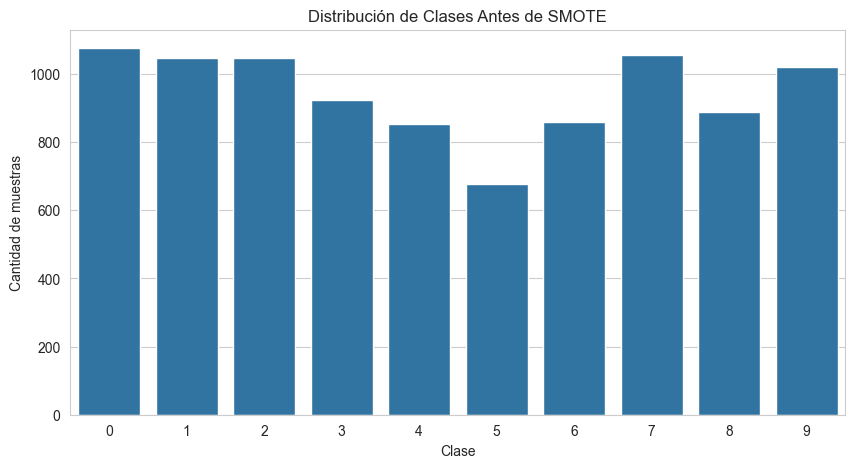

In [66]:
# Visualizar la distribución de clases antes de aplicar SMOTE
plot_distribution(y, "Distribución de Clases Antes de SMOTE")

In [67]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_haralick_resampled, y_resampled = smote.fit_resample(X_haralick, y)
X_hog_resampled, _ = smote.fit_resample(X_hog, y)
X_lbp_resampled, _ = smote.fit_resample(X_lbp, y)
X_combined_resampled, _ = smote.fit_resample(X_combined, y)

Distribución de clases (Distribución de Clases Después de SMOTE): Counter({7: 1076, 2: 1076, 8: 1076, 6: 1076, 3: 1076, 4: 1076, 0: 1076, 9: 1076, 1: 1076, 5: 1076})


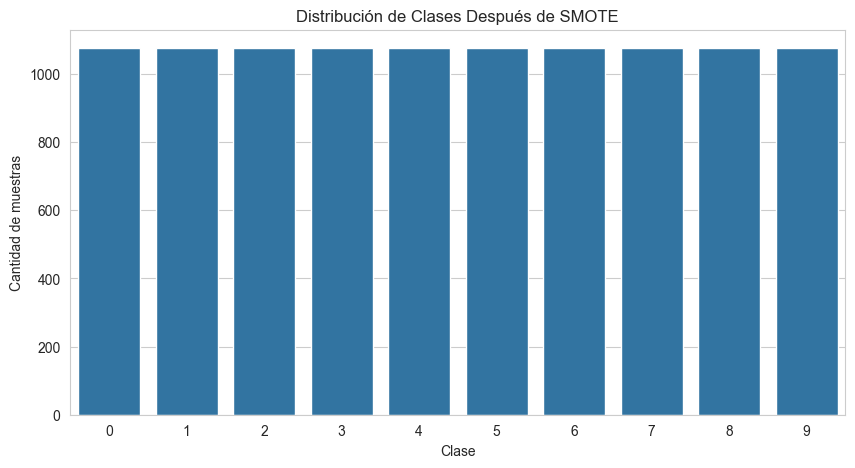

In [68]:
# Visualizar la distribución de clases después de aplicar SMOTE
plot_distribution(y_resampled, "Distribución de Clases Después de SMOTE")

Resultados para Haralick (GLCM):
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       197
           1       0.86      0.89      0.88       227
           2       0.45      0.47      0.46       227
           3       0.35      0.17      0.23       216
           4       0.79      0.88      0.83       207
           5       0.59      0.72      0.65       222
           6       0.40      0.53      0.46       209
           7       0.83      0.86      0.85       222
           8       0.69      0.37      0.48       208
           9       0.94      0.95      0.95       217

    accuracy                           0.66      2152
   macro avg       0.65      0.65      0.64      2152
weighted avg       0.65      0.66      0.64      2152



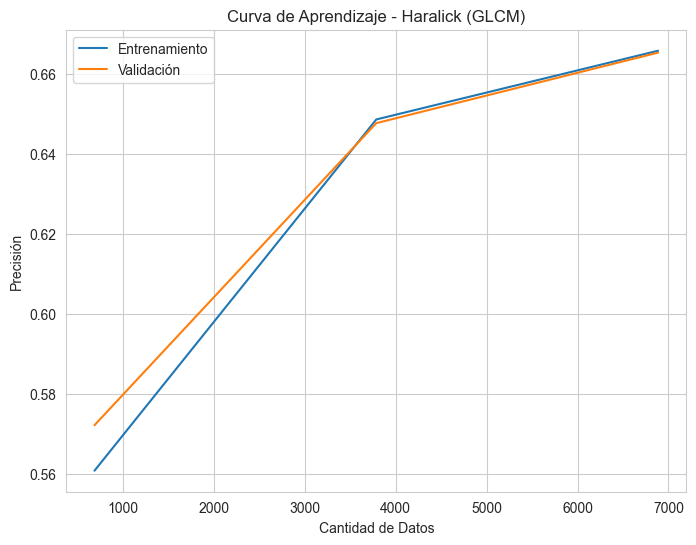

In [69]:
# Entrenamiento y evaluación con Haralick (GLCM)
X_train_haralick, X_test_haralick, y_train_haralick, y_test_haralick, y_pred_haralick = train_model(
    X_haralick_resampled, y_resampled)

evaluate_model(y_test_haralick, y_pred_haralick, "Haralick (GLCM)", X_train_haralick, y_train_haralick)

Resultados para HOG:
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       197
           1       0.86      0.87      0.87       227
           2       0.46      0.55      0.50       227
           3       0.59      0.62      0.61       216
           4       0.68      0.69      0.68       207
           5       0.75      0.68      0.72       222
           6       0.48      0.41      0.44       209
           7       0.80      0.72      0.76       222
           8       0.60      0.58      0.59       208
           9       0.96      0.97      0.97       217

    accuracy                           0.67      2152
   macro avg       0.67      0.67      0.67      2152
weighted avg       0.68      0.67      0.67      2152



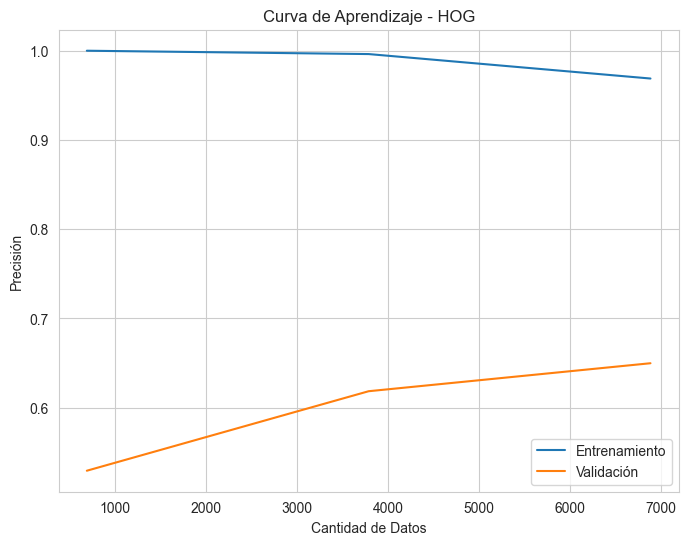

In [70]:
# Entrenamiento y evaluación con HOG
X_train_hog, X_test_hog, y_train_hog, y_test_hog, y_pred_hog = train_model(
    X_hog_resampled, y_resampled)

evaluate_model(y_test_hog, y_pred_hog, "HOG", X_train_hog, y_train_hog)

Resultados para LBP:
              precision    recall  f1-score   support

           0       0.13      0.18      0.15       197
           1       0.35      0.30      0.32       227
           2       0.21      0.22      0.21       227
           3       0.32      0.34      0.33       216
           4       0.40      0.47      0.43       207
           5       0.53      0.56      0.55       222
           6       0.43      0.42      0.42       209
           7       0.33      0.25      0.28       222
           8       0.48      0.39      0.43       208
           9       0.90      0.87      0.88       217

    accuracy                           0.40      2152
   macro avg       0.41      0.40      0.40      2152
weighted avg       0.41      0.40      0.40      2152



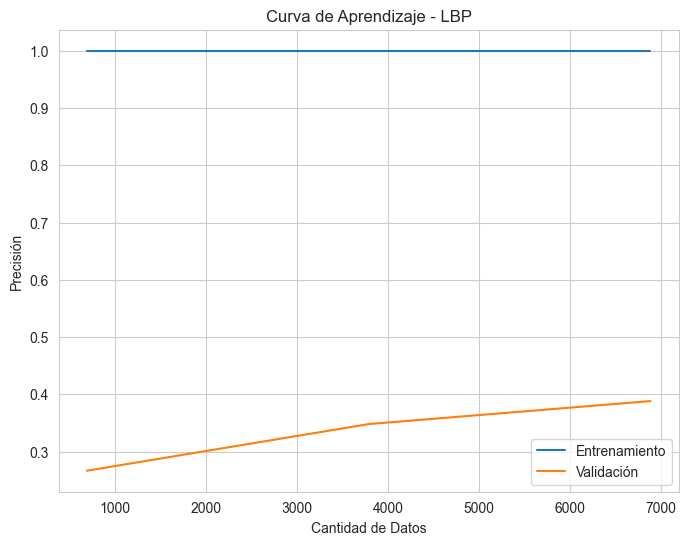

In [71]:
# Entrenamiento y evaluación con LBP
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp, y_pred_lbp = train_model(
    X_lbp_resampled, y_resampled)

evaluate_model(y_test_lbp, y_pred_lbp, "LBP", X_train_lbp, y_train_lbp)

Resultados para Haralick + HOG + LBP:
              precision    recall  f1-score   support

           0       0.16      0.23      0.19       197
           1       0.35      0.30      0.32       227
           2       0.23      0.25      0.24       227
           3       0.34      0.36      0.35       216
           4       0.76      0.67      0.71       207
           5       0.54      0.57      0.55       222
           6       0.42      0.44      0.43       209
           7       0.39      0.28      0.32       222
           8       0.47      0.42      0.45       208
           9       0.90      0.87      0.88       217

    accuracy                           0.44      2152
   macro avg       0.45      0.44      0.44      2152
weighted avg       0.45      0.44      0.44      2152



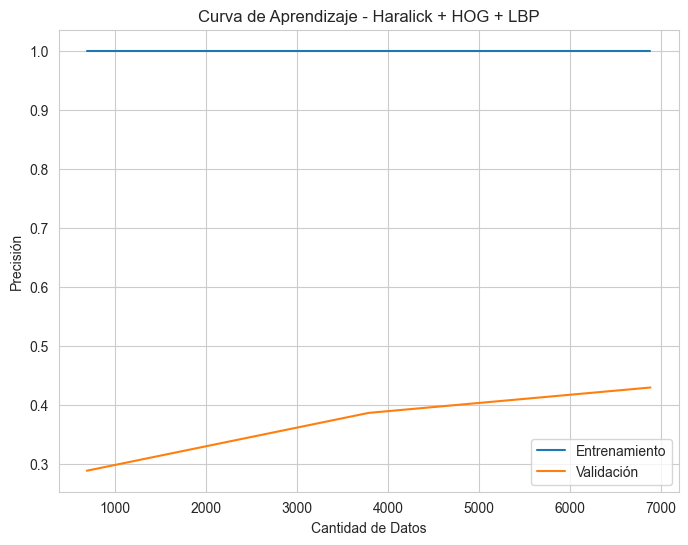

In [72]:
# Entrenamiento y evaluación combinando todos los extractores de características
X_train_combined, X_test_combined, y_train_combined, y_test_combined, y_pred_combined = train_model(
    X_combined_resampled, y_resampled)

evaluate_model(y_test_combined, y_pred_combined, "Haralick + HOG + LBP", X_train_combined, y_train_combined)

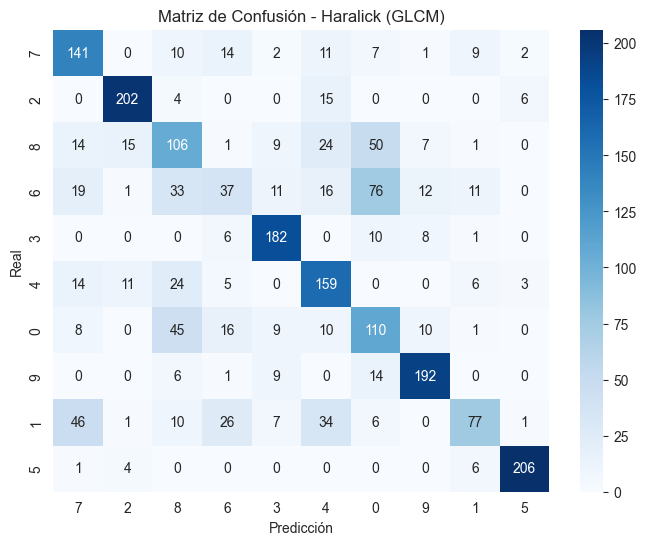

In [73]:
# Mostrar la matriz de confusión para Haralick (GLCM)
plot_confusion_matrix(y_test_haralick, y_pred_haralick, "Haralick (GLCM)", label_map)

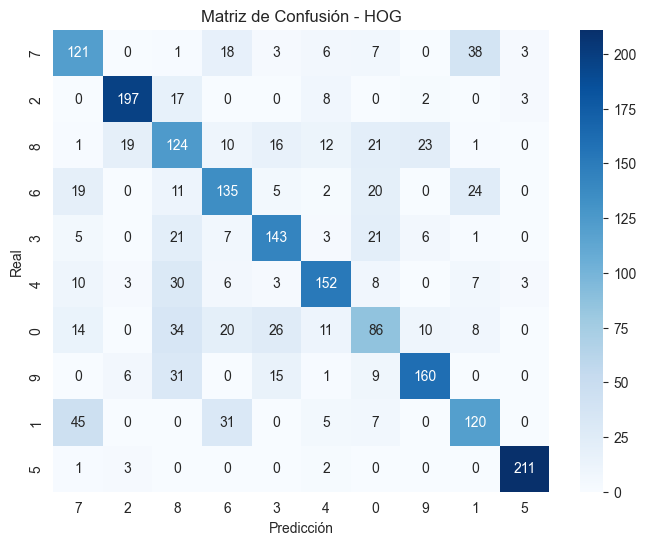

In [74]:
# Mostrar la matriz de confusión para HOG
plot_confusion_matrix(y_test_hog, y_pred_hog, "HOG", label_map)

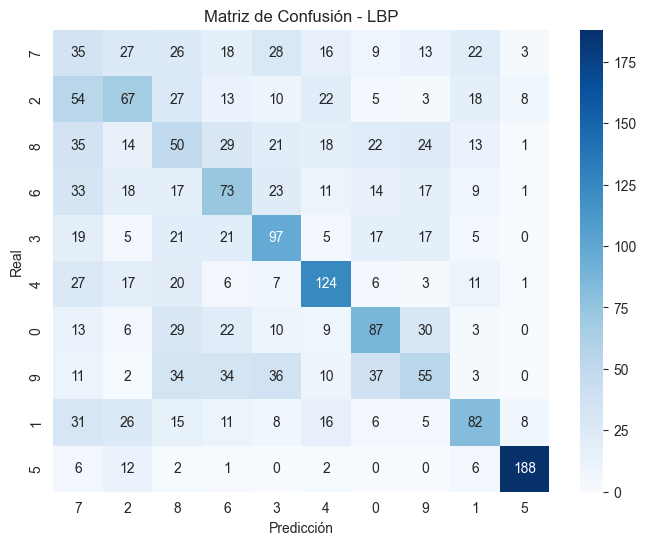

In [75]:
# Mostrar la matriz de confusión para LBP
plot_confusion_matrix(y_test_lbp, y_pred_lbp, "LBP", label_map)

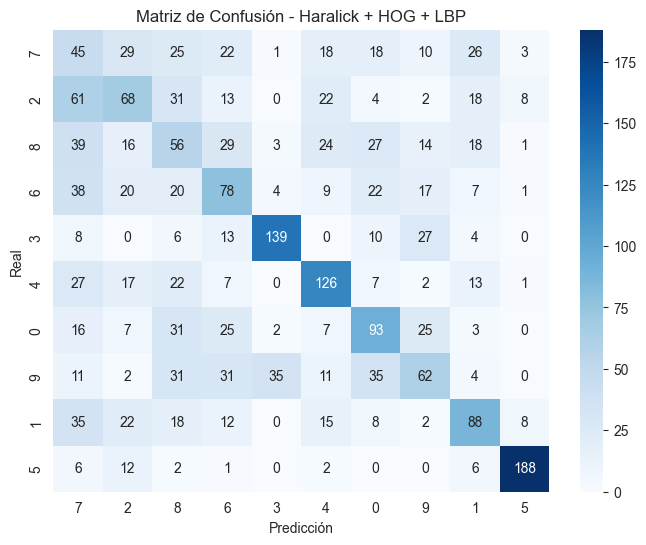

In [76]:
# Mostrar la matriz de confusión para la combinación de Haralick + HOG + LBP
plot_confusion_matrix(y_test_combined, y_pred_combined, "Haralick + HOG + LBP", label_map)